In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16, Xception, InceptionV3, MobileNet, ResNet50
from tensorflow.keras.preprocessing import image

In [2]:
batch_size = 32
shape = (224, 224)

# data augmentation
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True, 
    width_shift_range=0.1, 
    height_shift_range=0.2, 
    rotation_range=10, 
    zoom_range=0.05, 
    brightness_range=[0.4, 0.8],
    fill_mode="reflect"
    ) 

train_generator = datagen.flow_from_directory(
    directory="subset_images/train",
    target_size=shape,
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
    class_mode="categorical",
    seed=2019)

valid_generator = datagen.flow_from_directory(
    directory="subset_images/valid",
    target_size=shape,
    color_mode="rgb",
    shuffle=True,
    batch_size=batch_size,
    class_mode="categorical",
    seed=2019)

test_generator = datagen.flow_from_directory(
    directory="subset_images/test",
    target_size=shape,
    color_mode="rgb",
    shuffle=False,
    batch_size=1,
    class_mode="categorical")

num_classes = len(train_generator.class_indices)

# create step size
STEP_SIZE_TRAIN=np.ceil(train_generator.n/train_generator.batch_size)
STEP_SIZE_VALID=np.ceil(valid_generator.n/valid_generator.batch_size)
STEP_SIZE_TEST=np.ceil(test_generator.n/test_generator.batch_size)

print(STEP_SIZE_TRAIN)
print(STEP_SIZE_VALID)
print(STEP_SIZE_TEST)

Found 4076 images belonging to 101 classes.
Found 1078 images belonging to 101 classes.
Found 1299 images belonging to 101 classes.
128.0
34.0
1299.0


In [3]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(shape[0], shape[1], 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), input_shape=(shape[0], shape[1], 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3, 3), padding='same', use_bias=False, kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation="softmax"))

In [4]:
# compile
model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.0001, decay=1e-6),
              metrics=['acc'])

In [5]:
# callbacks
earlyStopping = EarlyStopping(monitor="val_loss", patience=10, verbose=0, mode="min")
checkpoint = ModelCheckpoint(os.path.join("models", "model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5"), verbose=1, 
                             monitor="val_loss", save_best_only=True, mode="auto")
reduce_lr_loss = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode="min")

In [6]:
import missinglink
missinglink_callback = missinglink.KerasCallback()

In [ ]:
# fit base model
model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    callbacks=[missinglink_callback,earlyStopping, checkpoint, reduce_lr_loss],
                    epochs=10, verbose=2)

## Transfer Learning => MobileNet

In [58]:
# load base MobileNet
base_mn = MobileNet(weights='imagenet', include_top=False, input_shape=(shape[0], shape[1], 3))

In [59]:
top_block = base_mn.output

top_block = GlobalAveragePooling2D()(top_block) # pool over height/width to reduce number of parameters
top_block = Dense(256, activation='relu')(top_block) # add a Dense layer
predictions = Dense(num_classes, activation='softmax')(top_block) # add another Dense layer
mn_transfer = Model(inputs=base_mn.input, outputs=predictions)

In [60]:
# unfreeze last few layers
for i, layer in enumerate(reversed(mn_transfer.layers)):
    layer.trainable = True
    if i > 15:
        break

In [61]:
mn_transfer.compile(loss="categorical_crossentropy",
              optimizer=RMSprop(lr=0.0002),
              metrics=["acc"])

In [ ]:
# fit model
checkpoint3 = ModelCheckpoint(os.path.join("models","keras_models", "model-mobilenet-RMSprop0.0002-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5"), 
                              verbose=1, monitor="val_loss", save_best_only=True, mode="auto")
history_mn = mn_transfer.fit(train_generator,
                                       steps_per_epoch=STEP_SIZE_TRAIN,
                                       validation_data=valid_generator,
                                       validation_steps=STEP_SIZE_VALID,
                                       callbacks=[missinglink_callback,earlyStopping, checkpoint3],
                                       epochs=50, verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 128.0 steps, validate for 34.0 steps


/Users/dineshp/.pyenv/versions/3.7.6/lib/python3.7/site-packages/missinglink_kernel/callback/dispatchers/json_encoder.py:24: UserWarning: skipped MissingLinkJsonEncoder because of TypeError Object of type ResourceVariable is not JSON serializable
  warnings.warn(msg)


Epoch 1/50
127/128 [============================>.] - ETA: 8s - loss: 3.3241 - acc: 0.2727 
Epoch 00001: val_loss improved from inf to 2.76175, saving model to models/keras_models/model-mobilenet-RMSprop0.0002-001-0.274289-0.346939.h5
128/128 [==============================] - 1208s 9s/step - loss: 3.3159 - acc: 0.2743 - val_loss: 2.7617 - val_acc: 0.3469
Epoch 2/50
127/128 [============================>.] - ETA: 9s - loss: 1.4061 - acc: 0.6716 
Epoch 00002: val_loss improved from 2.76175 to 1.86082, saving model to models/keras_models/model-mobilenet-RMSprop0.0002-002-0.673454-0.520408.h5
128/128 [==============================] - 1232s 10s/step - loss: 1.3996 - acc: 0.6735 - val_loss: 1.8608 - val_acc: 0.5204
Epoch 3/50
127/128 [============================>.] - ETA: 8s - loss: 0.7063 - acc: 0.8321 
Epoch 00003: val_loss improved from 1.86082 to 1.39983, saving model to models/keras_models/model-mobilenet-RMSprop0.0002-003-0.831207-0.635436.h5
128/128 [==============================]

In [44]:
# load model
#model-mobilenet-RMSprop0.0002-001-0.930507-0.647776.h5
transfer = load_model(os.path.join("models","keras_models", "model-mobilenet-RMSprop0.0002-001-0.998528-0.692950.h5"))

In [45]:
# compile
transfer.compile(loss="categorical_crossentropy",
              optimizer=SGD(lr=0.0001), 
              metrics=["acc"])

In [46]:
# continue fitting
checkpoint3 = ModelCheckpoint(os.path.join("models", "keras_models", "model-mobilenet-RMSprop0.0002to0.0001-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5"), 
                              verbose=1, monitor="val_loss", save_best_only=True, mode="auto")
history_mn = transfer.fit(train_generator,
                                       steps_per_epoch=STEP_SIZE_TRAIN,
                                       validation_data=valid_generator,
                                       validation_steps=STEP_SIZE_VALID,
                                       callbacks=[missinglink_callback,earlyStopping, checkpoint3],
                                       epochs=10, verbose=1, initial_epoch=2)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 128.0 steps, validate for 34.0 steps


/Users/dineshp/.pyenv/versions/3.7.6/lib/python3.7/site-packages/missinglink_kernel/callback/dispatchers/json_encoder.py:24: UserWarning: skipped MissingLinkJsonEncoder because of TypeError Object of type ResourceVariable is not JSON serializable
  warnings.warn(msg)


Epoch 3/10
127/128 [============================>.] - ETA: 5s - loss: 0.0051 - acc: 0.9988 
Epoch 00003: val_loss improved from inf to 1.38249, saving model to models/keras_models/model-mobilenet-RMSprop0.0002to0.0001-003-0.998773-0.735622.h5
128/128 [==============================] - 769s 6s/step - loss: 0.0051 - acc: 0.9988 - val_loss: 1.3825 - val_acc: 0.7356
Epoch 4/10
127/128 [============================>.] - ETA: 5s - loss: 0.0042 - acc: 0.9990 
Epoch 00004: val_loss did not improve from 1.38249
128/128 [==============================] - 697s 5s/step - loss: 0.0042 - acc: 0.9990 - val_loss: 1.4029 - val_acc: 0.7180
Epoch 5/10
127/128 [============================>.] - ETA: 5s - loss: 0.0044 - acc: 0.9990 
Epoch 00005: val_loss did not improve from 1.38249
128/128 [==============================] - 740s 6s/step - loss: 0.0043 - acc: 0.9990 - val_loss: 1.4465 - val_acc: 0.7273
Epoch 6/10
127/128 [============================>.] - ETA: 5s - loss: 0.0038 - acc: 0.9998 
Epoch 00006: 

In [47]:
# evaluate
val_loss, val_acc = transfer.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID, verbose=1)
print("Val Loss: {} \nVal Accuracy: {}".format(val_loss, val_acc))

  ...
    to  
  ['...']
34/34 [==============================] - 57s 2s/step - loss: 1.4258 - acc: 0.7199
Val Loss: 1.425831345950856 
Val Accuracy: 0.719851553440094


In [48]:
# predict test images
test_generator.reset()
pred = transfer.predict(test_generator, steps=STEP_SIZE_TEST, verbose=1)

1299/1299 [==============================] - 85s 66ms/step


In [49]:
# clean predictions
predictions = pred.argmax(axis=-1)
labels = (test_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predictions]

In [50]:
# create prediction dataframe
filenames = test_generator.filenames
correct_labels = [filename[:filename.find("/")] for filename in filenames]
results = pd.DataFrame({"Filename": filenames, "Labels": correct_labels, "Predicted Label": predicted_labels})

In [51]:
results

,Filename,Labels,Predicted Label
0,apple pie/apple pie_12.jpg,apple pie,apple pie
1,apple pie/apple pie_13.jpg,apple pie,pancakes
2,apple pie/apple pie_16.jpg,apple pie,apple pie
3,apple pie/apple pie_29.jpg,apple pie,apple pie
4,apple pie/apple pie_34.jpg,apple pie,bread pudding
...,...,...,...
1294,waffles/waffles_47.jpg,waffles,waffles
1295,waffles/waffles_49.jpg,waffles,pancakes
1296,waffles/waffles_50.jpg,waffles,waffles
1297,waffles/waffles_58.jpg,waffles,waffles


In [52]:
## Plots the distribution of the predictions for a given dish


def plot_predictions_for_class(data, class_id, figsize=(10,7)):
   
    subset = data[data["Labels"] == class_id]
    plt.figure(figsize=figsize)
    plt.title("Count per Predicted Label")
    plt.xlabel("Food Item")
    plt.ylabel("Count")
    value_counts = subset["Predicted Label"].value_counts().plot(kind="bar")
    return value_counts

## Returns top k most accurate predictions
    
def get_most_accurate(data, k=1):

    subset = data[data["Labels"]==data["Predicted Label"]]
    results = (subset["Labels"].value_counts()/data["Labels"].value_counts()).sort_values(ascending=False)[:k]
    return results

In [53]:
get_most_accurate(results,10)

edamame                    1.000000
red velvet cake            1.000000
cup cakes                  1.000000
pizza                      0.970297
fried rice                 0.916667
grilled cheese sandwich    0.916667
tuna tartare               0.916667
guacamole                  0.916667
chocolate cake             0.916667
hot and sour soup          0.916667
Name: Labels, dtype: float64

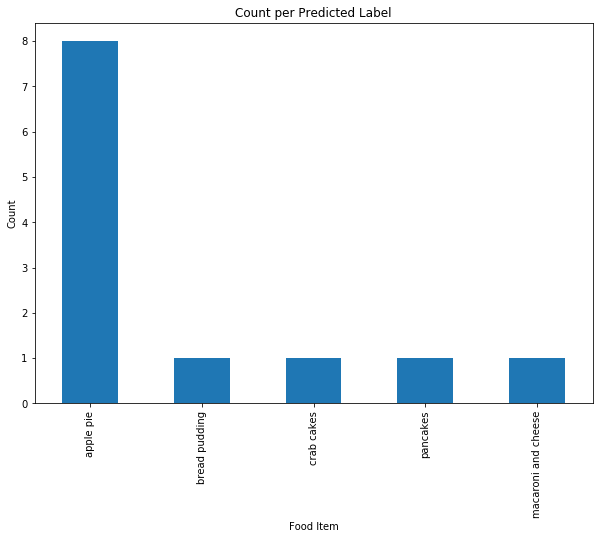

In [54]:
plot_predictions_for_class(results, "apple pie")

Actual: breakfast burrito_361.jpg
Predicted: cannoli


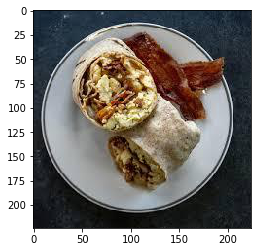

In [55]:
# predict 1 image
source = "valid"
random_folder = np.random.choice(os.listdir(os.path.join("images", source)))
random_image = np.random.choice(os.listdir(os.path.join("images", source, random_folder)))
img = image.load_img(os.path.join( "images", source, random_folder, random_image), target_size = (shape[0], shape[1]))
plt.imshow(img)
img = image.img_to_array(img) / 255
img = np.expand_dims(img, axis = 0)

print("Actual:", random_image)
print("Predicted:", labels[transfer.predict(img).argmax(axis=-1)[0]])

In [56]:
score = transfer.evaluate_generator(test_generator)

  ...
    to  
  ['...']


In [57]:
score

[1.3246215166754547, 0.73364127]